In [55]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import time

import itertools  

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Задача классификации токсичных комментариев




### Агафонов Артём

# Данные

1. 1804874 комментариев с платформы Civil Comments
2. Каждому комментарию поставлена оценка токсичности, по результатам опроса нескольких людей
3. Также есть некоторые дополнительные аттрибуты

## Считываем данные

In [26]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [27]:
data.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
id                                     int64
target                                 float64
comment_text                           object
severe_toxicity                        float64
obscene                                float64
identity_attack                        float64
insult                                 float64
threat                                 float64
asian                                  float64
atheist                                float64
bisexual                               float64
black                                  float64
buddhist                               float64
christian                              float64
female                                 float64
heterosexual                           float64
hindu                                  float64
homosexual_gay_or_lesbian              float64
intellectual_or_learning_disability    float

In [29]:
train = data.copy()
train = train[['target', 'comment_text']]
train['target'] = np.where(train['target'] < 0.5, 0, 1)

In [30]:
train.head()

,target,comment_text
0,0,"This is so cool. It's like, 'would you want yo..."
1,0,Thank you!! This would make my life a lot less...
2,0,This is such an urgent design problem; kudos t...
3,0,Is this something I'll be able to install on m...
4,1,haha you guys are a bunch of losers.


Будем рассматривать эту задачу, как задачу бинарной классификации

In [31]:
X = train['comment_text']
train['target'] = np.where(train['target'] < 0.5, 0, 1)
y = train['target']

## Визуализация данных

Посмотрим на распределение таргета.

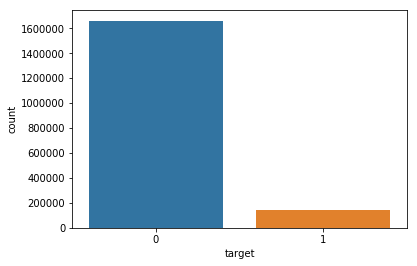

In [13]:
ax = sns.countplot(x=y)

Кажется логичным предположить, что капс и восклицательные знаки более свойственны токсичным комментариям. Проверим это. Также изучим зависимость токсичности от некоторых других признаков, таких как длина комментария и т.д.

In [9]:
def capitals(comm):
    cnt = 0
    for sym in comm:
        if sym.isupper():
            cnt = cnt + 1
    return cnt    

In [10]:
def smilies(comm):
    smilies = [':-)', ':)', ':(', ':-(']
    cnt = 0
    for sym in smilies:
        cnt = cnt + comm.count(sym)
    return cnt    

Добавим в наши данные соответствующие признаки

In [11]:
train['len'] = train['comment_text'].apply(len)
train['exclam'] = train['comment_text'].apply(lambda comm: comm.count('!'))

In [12]:
train['capitals'] = train['comment_text'].apply(capitals)

In [13]:
train['caps_per_len'] = train['capitals']/train['len']

In [14]:
train['smilies'] = train['comment_text'].apply(smilies)

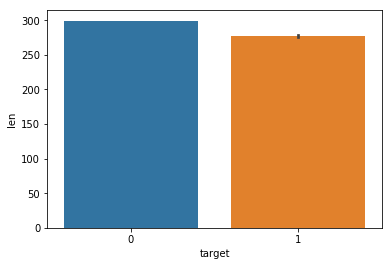

In [46]:
ax = sns.barplot(x = 'target', y= 'len', data=train)
plt.title('length')

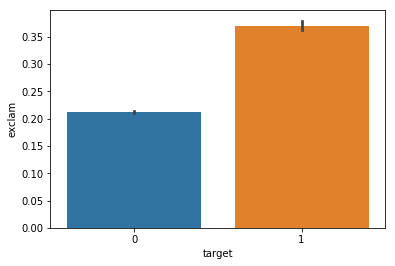

In [19]:
ax = sns.barplot(x = 'target', y= 'exclam', data=train)

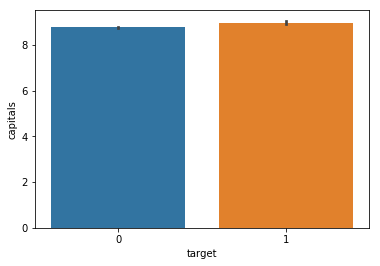

In [22]:
ax = sns.barplot(x = 'target', y= 'capitals', data=train)

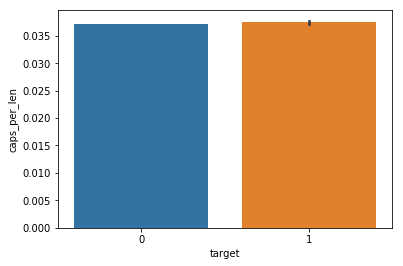

In [24]:
ax = sns.barplot(x = 'target', y= 'caps_per_len', data=train)

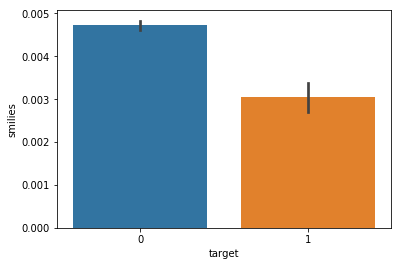

In [25]:
ax = sns.barplot(x = 'target', y= 'smilies', data=train)

## Вывод:
1. Данные несбалансированы
2. Объем данных очень большой
3. Число восклицательных знаков и смайликов действительно отличается между классами

Разделим данные на тренировочную и тестовую выборки

In [14]:
X_train, X_test, y_train, y_test = train_test_split(train['comment_text'], train['target'], test_size=0.333, random_state = 1)

## TFIDF и логистиеская регрессия

In [15]:
class LengthExtractor(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def transform(self, df, y=None):
        ret = df.apply(len).values.reshape(-1, 1)
        print(ret.shape)
        return ret

    def fit(self, df, y=None):
        return self
    

class ExclamExtractor(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def transform(self, df, y=None):
        return df.apply(lambda comm: comm.count('!')).values.reshape(-1,1)

    def fit(self, df, y=None):
        return self
    

class CapitalsExtractor(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def capitals(self, comm):
        cnt = 0
        for sym in comm:
            if sym.isupper():
                cnt = cnt + 1
        return cnt    

    def transform(self, df, y=None):
        return df.apply(self.capitals).values.reshape(-1,1)

    def fit(self, df, y=None):
        return self
    
    
class SmiliesExtractor(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def smilies(self, comm):
        smilies = [':-)', ':)', ':(', ':-(']
        cnt = 0
        for sym in smilies:
            cnt = cnt + comm.count(sym)
        return cnt       

    def transform(self, df, y=None):
        return df.apply(self.smilies).values.reshape(-1,1)

    def fit(self, df, y=None):
        return self
    

In [61]:
pipeline = Pipeline([
    ('feats', FeatureUnion([
        ('len', LengthExtractor()),
        ('exclam', ExclamExtractor()),
        ('cap', CapitalsExtractor()),
        ('smile', SmiliesExtractor()),
        ('tfidf', TfidfVectorizer(stop_words = 'english')),
    ])),
    ('clf', LogisticRegression(random_state = 1))  # classifier
])

In [62]:
pipeline.get_params()

{'memory': None, 'steps': [('feats', FeatureUnion(n_jobs=None,
          transformer_list=[('len', LengthExtractor()), ('exclam', ExclamExtractor()), ('cap', CapitalsExtractor()), ('smile', SmiliesExtractor()), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
           ...
           token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
           vocabulary=None))],
          transformer_weights=None)),
  ('clf',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='warn',
             n_jobs=None, penalty='l2', random_state=1, solver='warn',
             tol=0.0001, verbose=0, warm_start=False))], 'feats': FeatureUnion(n_jobs=None,
        transformer_list=[('len', LengthExtractor()), ('exclam', ExclamExtractor()), ('cap', CapitalsExtractor()), ('smile', SmiliesExtractor()), ('tfi

In [63]:
param_grid = {'clf__penalty': ['l1', 'l2'],
             'clf__C': [0.05, 0.1, 0.5, 1, 5]}

In [64]:
grid_cv = GridSearchCV(pipeline, param_grid, scoring = 'roc_auc', cv = 3, n_jobs = -1)

In [65]:
start_time = time.time()
grid_cv.fit(X_train, y_train)
#grid_cv.fit(train['comment_text'], train['target'])
print("--- %s seconds ---" % (time.time() - start_time))

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


(1203850, 1)


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


--- 4764.354368925095 seconds ---


In [66]:
grid_cv.best_estimator_

Pipeline(memory=None,
     steps=[('feats', FeatureUnion(n_jobs=None,
       transformer_list=[('len', LengthExtractor()), ('exclam', ExclamExtractor()), ('cap', CapitalsExtractor()), ('smile', SmiliesExtractor()), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.floa...e, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [67]:
print (grid_cv.best_score_)
print (grid_cv.best_params_)

0.9461002360758146
{'clf__C': 1, 'clf__penalty': 'l1'}


(601024, 1)


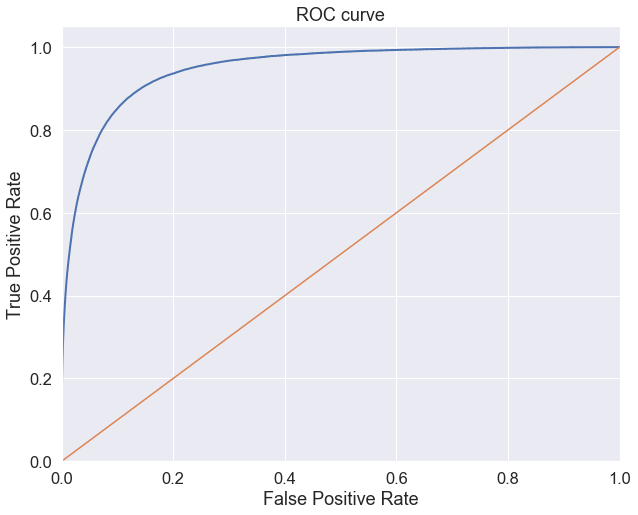

In [68]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, grid_cv.best_estimator_.predict_proba(X_test)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [69]:
y_pred = grid_cv.best_estimator_.predict(X_test)

(601024, 1)


In [70]:
print (classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97    569819
           1       0.50      0.76      0.60     31205

   micro avg       0.95      0.95      0.95    601024
   macro avg       0.74      0.86      0.79    601024
weighted avg       0.96      0.95      0.95    601024



Confusion matrix, without normalization
[[545627   7381]
 [ 24192  23824]]


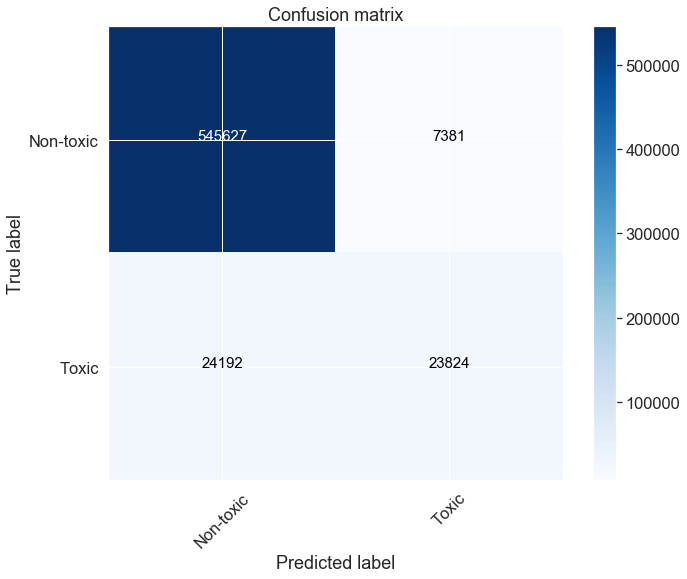

In [71]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-toxic', 'Toxic'],
                      title='Confusion matrix')

## Мешок слов + наивный байес

In [42]:
pipeline2 = Pipeline([
    ('count', CountVectorizer(stop_words = 'english')),
    ('clfNB', MultinomialNB())
])

In [44]:
param_grid2 = {'clfNB__alpha': [0.0001, 0.001, 0.1, 0.3, 0.5, 1]}

In [45]:
grid_cv2 = GridSearchCV(pipeline2, param_grid2, scoring = 'roc_auc', cv = 3, n_jobs = -1)

In [46]:
grid_cv2.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocesso...zer=None, vocabulary=None)), ('clfNB', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'clfNB__alpha': [0.0001, 0.001, 0.1, 0.3, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [47]:
print (grid_cv2.best_score_)
print (grid_cv2.best_params_)

0.8562023000312362
{'clfNB__alpha': 0.3}


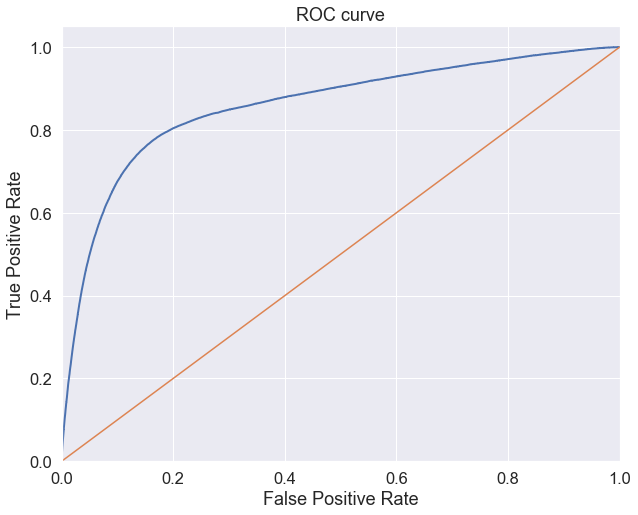

In [48]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, grid_cv2.best_estimator_.predict_proba(X_test)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [58]:
y_pred2 = grid_cv2.best_estimator_.predict(X_test)

In [59]:
print (classification_report(y_pred2, y_test))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94    530899
           1       0.60      0.41      0.49     70125

   micro avg       0.90      0.90      0.90    601024
   macro avg       0.76      0.69      0.72    601024
weighted avg       0.89      0.90      0.89    601024



Confusion matrix, without normalization
[[511742  41266]
 [ 19157  28859]]


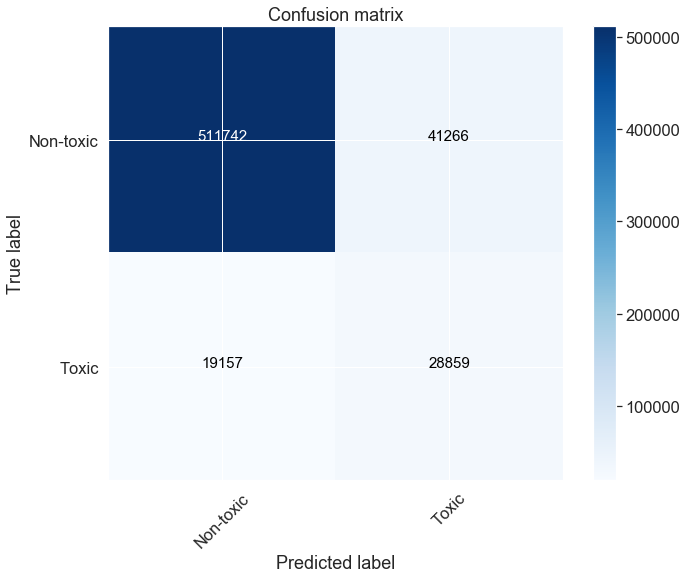

In [60]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_pred2)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-toxic', 'Toxic'],
                      title='Confusion matrix')

## Наивный байес + TFIDF

In [72]:
pipeline3 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = 'english', smooth_idf = True)),
    ('clfNB', MultinomialNB())
])

In [80]:
param_grid3 = {'clfNB__alpha': [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 1]}

In [81]:
grid_cv3 = GridSearchCV(pipeline3, param_grid3, scoring = 'roc_auc', cv = 3, n_jobs = -1)

In [82]:
grid_cv3.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...e,
        vocabulary=None)), ('clfNB', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'clfNB__alpha': [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [83]:
print (grid_cv3.best_score_)
print (grid_cv3.best_params_)

0.8655751813122871
{'clfNB__alpha': 0.1}


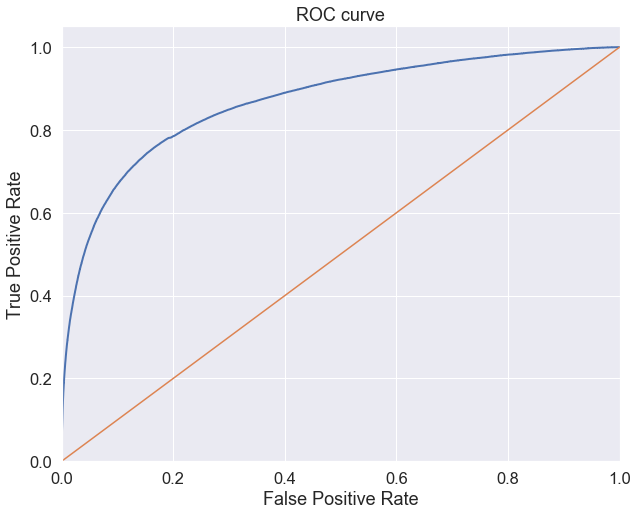

In [84]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, grid_cv3.best_estimator_.predict_proba(X_test)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [85]:
y_pred3 = grid_cv3.best_estimator_.predict(X_test)

In [86]:
print (classification_report(y_pred3, y_test))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96    595639
           1       0.10      0.87      0.17      5385

   micro avg       0.93      0.93      0.93    601024
   macro avg       0.55      0.90      0.57    601024
weighted avg       0.99      0.93      0.95    601024



Confusion matrix, without normalization
[[552289    719]
 [ 43350   4666]]


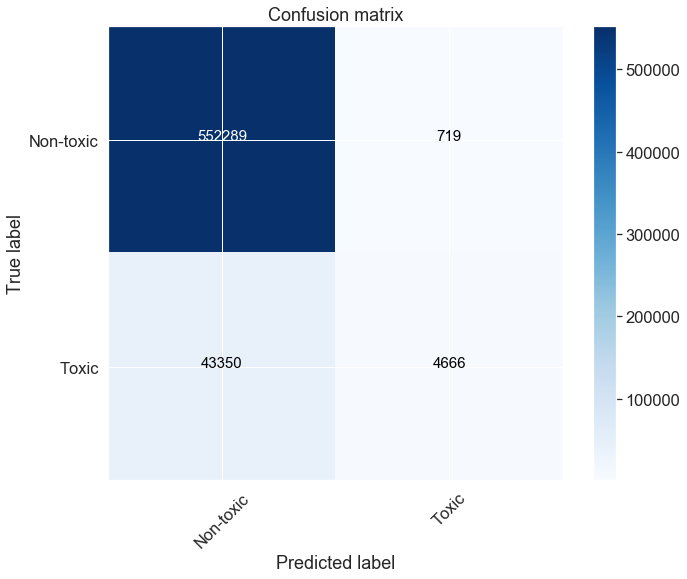

In [87]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_pred3)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-toxic', 'Toxic'],
                      title='Confusion matrix')

# Результаты

## Метрика с Kaggle

### TF-IDF + Логистическая регрессия 0.89683
### Bag of Words + Наивный байесовский классификатор 0.79944
### TF-IDF + Наивный байесовский классификатор 0.79652


# Вывод

- наилучший результат показала логистическая регрессия
- наивный байесовский классификатор показал 
- большой объем данных сильно усложняет работу
- наивный байессовский классификатор в силу простоты модели работает быстрее логистической регрессии, но показывает результаты хуже
- на тестовой выборке при подборе гиперпараметров наивный байесовский классификатор с ti-idf сильно ошибался на классе токсичных комментариев, но на kaggle оба классификатора дали примерно одинаковый скор
- заметим, что предсказание нулями дает скор 0.5 на kaggle